In [1]:
from Unet_model import simple_unet_model   #Use normal unet model
from keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

In [2]:
image_directory = r'D:\02-Project\01-Wear Detection\07-Scripts\debug_environment\debug_environment\Ehsan\images_Aug/'
mask_directory = r'D:\02-Project\01-Wear Detection\07-Scripts\debug_environment\debug_environment\Ehsan\masks_Aug/'
#validation_directory = r'D:\02-Project\01-Wear Detection\07-Scripts\debug_environment\debug_environment\TestImages\Orginal_Images_Aligned_Cropped_tif/'

In [4]:
image_directory = r'D:\02-Project\01-Wear Detection\10_Training_Dataset\Images\All/'
mask_directory = r'D:\02-Project\01-Wear Detection\10_Training_Dataset\Masks\All/'
#validation_directory = r'D:\02-Project\01-Wear Detection\07-Scripts\debug_environment\debug_environment\TestImages\Orginal_Images_Aligned_Cropped_tif/'

In [5]:
SIZE = 512
image_dataset = []  #Many ways to handle data, you can use pandas. Here, we are using a list format.  
mask_dataset = []  #Place holders to define add labels. We will add 0 to all parasitized images and 1 to uninfected.
validation_dataset = []

images = os.listdir(image_directory)
for i, image_name in enumerate(images):    #Remember enumerate method adds a counter and returns the enumerate object
    if (image_name.split('.')[1] == 'tif'):
        #print(image_directory+image_name)
        image = cv2.imread(image_directory+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        image_dataset.append(np.array(image))

#Iterate through all images in Uninfected folder, resize to 64 x 64
#Then save into the same numpy array 'dataset' but with label 1

masks = os.listdir(mask_directory)
for i, image_name in enumerate(masks):
    if (image_name.split('.')[1] == 'tif'):
        image = cv2.imread(mask_directory+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        mask_dataset.append(np.array(image))

In [6]:
#Normalize images
image_dataset = np.expand_dims(normalize(np.array(image_dataset), axis=1),3)
#D not normalize masks, just rescale to 0 to 1.
mask_dataset = np.expand_dims((np.array(mask_dataset)),3) /255.

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.10, random_state = 0)

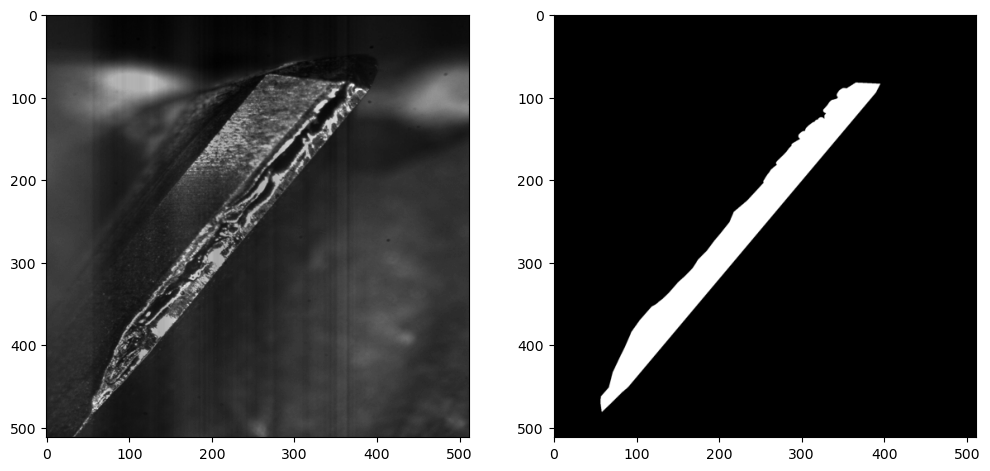

In [13]:
#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (512, 512)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (512, 512)), cmap='gray')
plt.show()


In [10]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

In [11]:
def get_model():
    return simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [12]:
model = get_model()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 512, 512, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [13]:
#If starting with pre-trained weights. 
#model.load_weights('mitochondria_gpu_tf1.4.hdf5')

history = model.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=5, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

model.save(r'D:\02-Project\01-Wear Detection\07-Scripts\debug_environment\debug_environment\Model\TEST_Ehsan_Aug_Test.hdf5')

Epoch 1/5
9/9 [==============================] - 61s 7s/step - loss: 0.6017 - accuracy: 0.7750 - val_loss: 0.1260 - val_accuracy: 0.9906
Epoch 2/5
9/9 [==============================] - 63s 7s/step - loss: 0.1323 - accuracy: 0.9891 - val_loss: 0.0684 - val_accuracy: 0.9906
Epoch 3/5
9/9 [==============================] - 62s 7s/step - loss: 0.0838 - accuracy: 0.9901 - val_loss: 0.0736 - val_accuracy: 0.9906
Epoch 4/5
9/9 [==============================] - 63s 7s/step - loss: 0.0640 - accuracy: 0.9902 - val_loss: 0.0914 - val_accuracy: 0.9906
Epoch 5/5
9/9 [==============================] - 66s 7s/step - loss: 0.0544 - accuracy: 0.9902 - val_loss: 0.0707 - val_accuracy: 0.9906


In [82]:
#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

2/2 [==============================] - 3s 652ms/step
IoU socre is:  0.8969500802610457


2/2 [==============================] - 3s 766ms/step - loss: 0.0140 - accuracy: 0.9919
Accuracy =  99.18541312217712 %


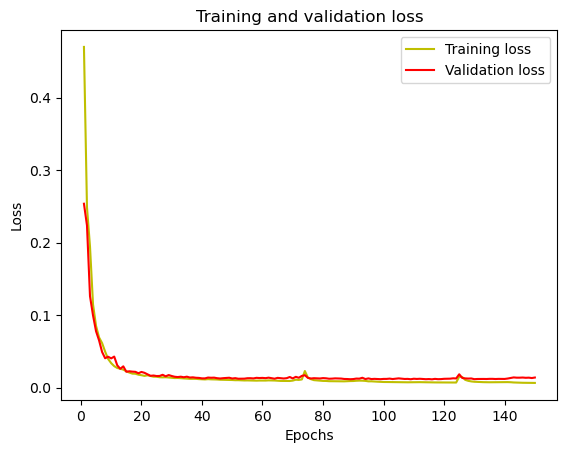

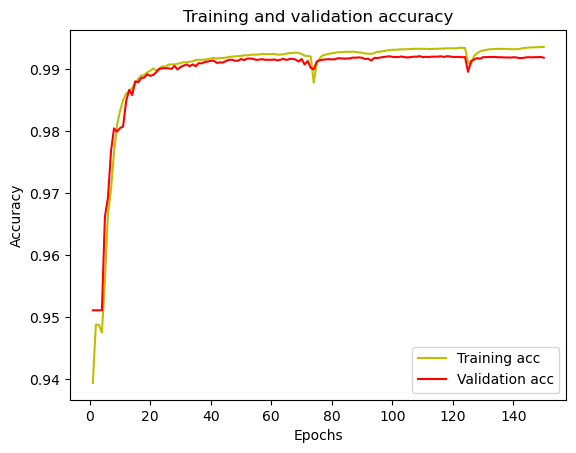

In [88]:
#Evaluate the model


	# evaluate model
_, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")


#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
#acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

1/1 [==============================] - 0s 369ms/step


NameError: name 'test_img_other' is not defined

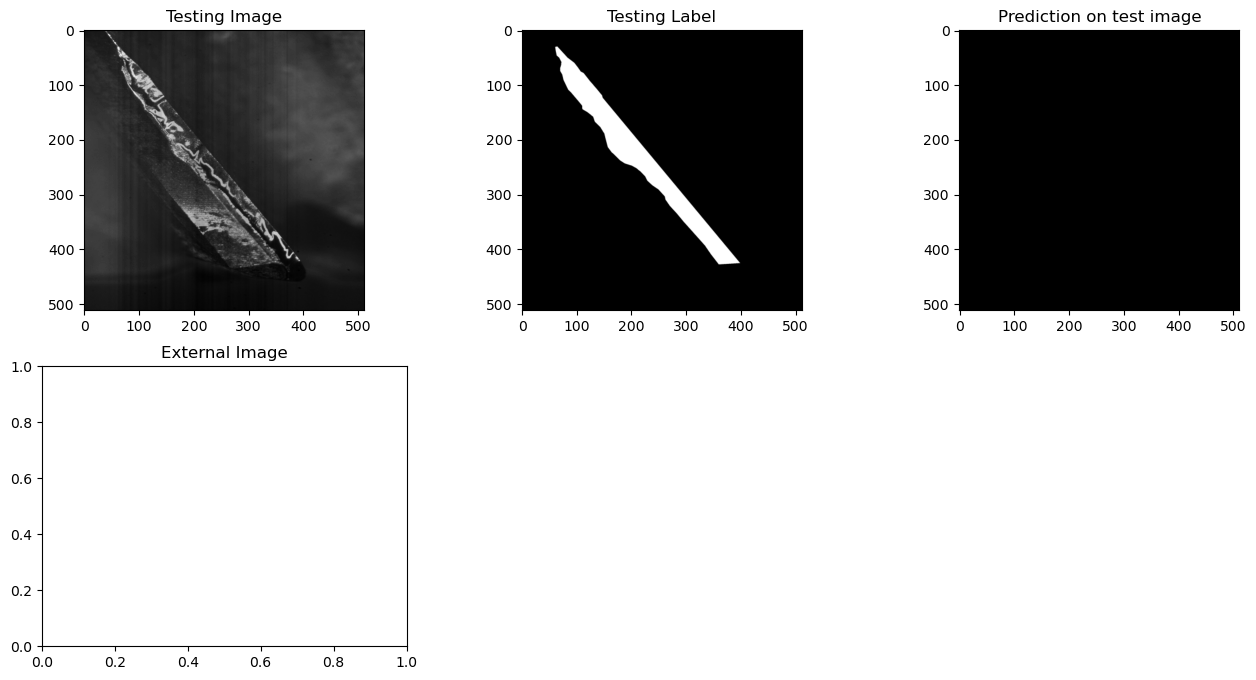

In [10]:
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.2).astype(np.uint8)


plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')
plt.subplot(234)
plt.title('External Image')
plt.imshow(test_img_other, cmap='gray')
plt.subplot(235)
plt.title('Prediction of external Image')
plt.imshow(prediction_other, cmap='gray')
plt.show()

In [11]:
#Predict on a few images
#model = get_model()
model.load_weights(r'D:\02-Project\01-Wear Detection\07-Scripts\debug_environment\debug_environment\Model\TEST_Ehsan_Aug.hdf5') #Trained for 50 epochs and then additional 100

1/1 [==============================] - 0s 98ms/step


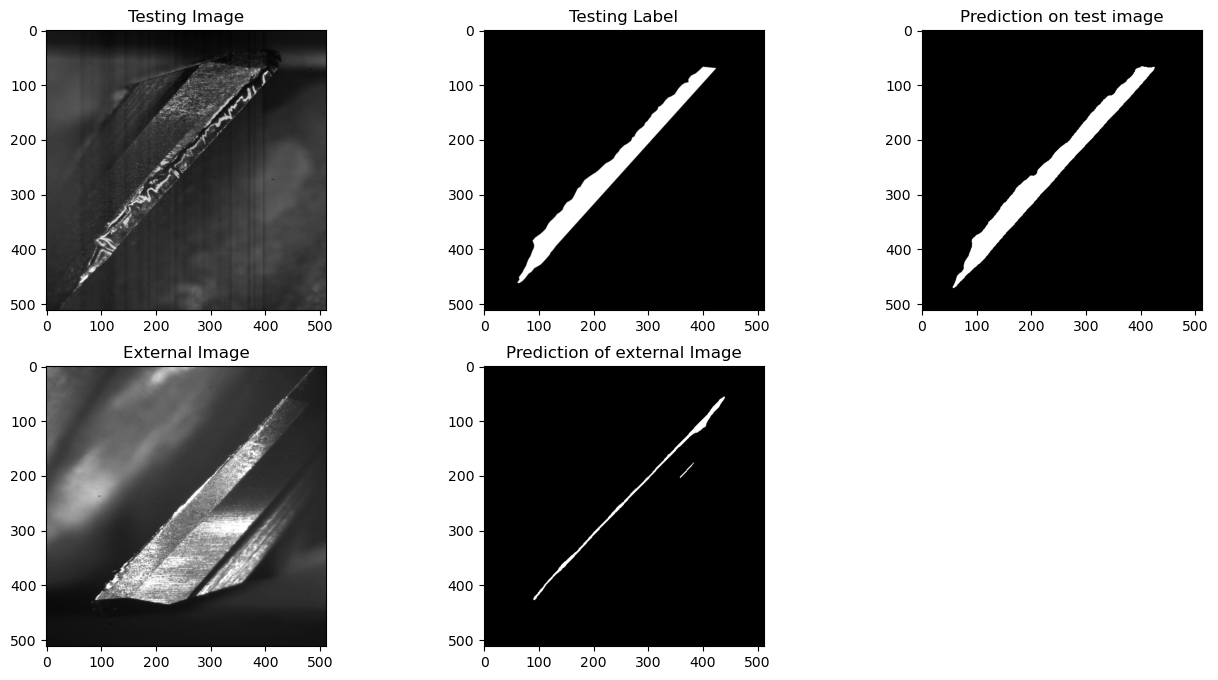

In [12]:
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.2).astype(np.uint8)

test_img_other = cv2.imread(r"D:\02-Project\01-Wear Detection\07-Scripts\debug_environment\debug_environment\TestImages\Orginal_Images_Aligned_Cropped_tif_512\image0001421_aligned_cropped.tif", 0)
#test_img_other = test_img_other.resize((SIZE, SIZE))
#test_img_other = cv2.imread('data/test_images/img8.tif', 0)
test_img_other_norm = np.expand_dims(normalize(np.array(test_img_other), axis=1),2)
test_img_other_norm=test_img_other_norm[:,:,0][:,:,None]
test_img_other_input=np.expand_dims(test_img_other_norm, 0)

#Predict and threshold for values above 0.5 probability
#Change the probability threshold to low value (e.g. 0.05) for watershed demo.
prediction_other = (model.predict(test_img_other_input)[0,:,:,0] > 0.2).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')
plt.subplot(234)
plt.title('External Image')
plt.imshow(test_img_other, cmap='gray')
plt.subplot(235)
plt.title('Prediction of external Image')
plt.imshow(prediction_other, cmap='gray')
plt.show()

In [28]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['acc']
#acc = history.history['accuracy']
val_acc = history.history['val_acc']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


NameError: name 'history' is not defined

In [ ]:
test_img_other = cv2.imread(r"D:\02-Project\01-Wear Detection\07-Scripts\debug_environment\debug_environment\TestImages\Orginal_Images_Aligned_Cropped_tif_512\image0001421_aligned_cropped.tif", 0)
#test_img_other = test_img_other.resize((SIZE, SIZE))
#test_img_other = cv2.imread('data/test_images/img8.tif', 0)
test_img_other_norm = np.expand_dims(normalize(np.array(test_img_other), axis=1),2)
test_img_other_norm=test_img_other_norm[:,:,0][:,:,None]
test_img_other_input=np.expand_dims(test_img_other_norm, 0)

#Predict and threshold for values above 0.5 probability
#Change the probability threshold to low value (e.g. 0.05) for watershed demo.
prediction_other = (model.predict(test_img_other_input)[0,:,:,0] > 0.2).astype(np.uint8)


In [14]:
input_folder = r'D:\02-Project\01-Wear Detection\07-Scripts\VB-Messung\Test_Image\Test1\Orginal_Aligned_Cropped_Resized/'
output_folder = r'D:\02-Project\01-Wear Detection\07-Scripts\VB-Messung\Test_Image\Test1\Orginal_Aligned_Cropped_Resized\per_aug/'

for filename in os.listdir(input_folder):
    if filename.endswith('.jpg'):  # Assuming you want to process TIFF images
        # Get the input image path
        img_path = os.path.join(input_folder, filename)

        # Read and normalize the image
        test_img_other = cv2.imread(img_path, 0)
        #test_img_other_norm = np.expand_dims((test_img_other.astype(float) - 0) / (255 - 0), 2)
        test_img_other_norm = np.expand_dims(normalize(np.array(test_img_other), axis=1),2)

        # Prepare input for prediction
        #test_img_other_norm = test_img_other_norm[:, :, 0][:, :, None]
        #test_img_other_input = np.expand_dims(test_img_other_norm, 0)

        test_img_other_norm=test_img_other_norm[:,:,0][:,:,None]
        test_img_other_input=np.expand_dims(test_img_other_norm, 0)

        # Predict and threshold for values above 0.2 probability
        prediction_other = (model.predict(test_img_other_input)[0, :, :, 0] > 0.2).astype(np.uint8)

        # Save the prediction as an image
        output_path = os.path.join(output_folder, f'{os.path.splitext(filename)[0]}_prediction.png')
        Image.fromarray(prediction_other * 255).save(output_path)  # Save as PNG

print("Prediction completed.")

1/1 [==============================] - 0s 167ms/step
Prediction completed.


In [3]:
#https://youtu.be/k4TqxHteJ7s
#https://youtu.be/mwN2GGA4mqo
"""
@author: Sreenivas Bhattiprolu
"""

import numpy as np
from matplotlib import pyplot as plt
from skimage.transform import AffineTransform, warp
from skimage import io, img_as_ubyte
import random
import os
from scipy.ndimage import rotate

images_to_generate=20
seed_for_random = 42

#Define functions for each operation
#Define seed for random to keep the transformation same for image and mask

# Make sure the order of the spline interpolation is 0, default is 3. 
#With interpolation, the pixel values get messed up.
def rotation(image, seed):
    random.seed(seed)
    angle= 180
    r_img = rotate(image, angle, mode='reflect', reshape=False, order=0)
    return r_img



def h_flip(image, seed):
    hflipped_img= np.fliplr(image)
    return  hflipped_img

def v_flip(image, seed):
    vflipped_img= np.flipud(image)
    return vflipped_img

def v_transl(image, seed):
    random.seed(seed)
    n_pixels = random.randint(-64,64)
    vtranslated_img = np.roll(image, n_pixels, axis=0)
    return vtranslated_img

def h_transl(image, seed):
    random.seed(seed)
    n_pixels = random.randint(-64,64)
    htranslated_img = np.roll(image, n_pixels, axis=1)
    return htranslated_img


'''
transformations = {'rotate': rotation,
                      'horizontal flip': h_flip, 
                      'vertical flip': v_flip,
                   'vertical shift': v_transl,
                   'horizontal shift': h_transl
                 }                #use dictionary to store names of functions 
'''
transformations = {'rotate': rotation,
                      'horizontal flip': h_flip, 
                      'vertical flip': v_flip
                 }                #use dictionary to store names of functions

images_path= r"D:\02-Project\01-Wear Detection\10_Training_Dataset\Images\raw_images_cropped_tif/" #path to original images
masks_path = r"D:\02-Project\01-Wear Detection\10_Training_Dataset\Masks\raw_masks_converted_cropped_tif/"
img_augmented_path= r"D:\02-Project\01-Wear Detection\10_Training_Dataset\Images\raw_images_cropped_tif_aug/" # path to store aumented images
msk_augmented_path= r"D:\02-Project\01-Wear Detection\10_Training_Dataset\Masks\raw_masks_converted_cropped_tif_aug/" # path to store aumented images
images=[] # to store paths of images from folder
masks=[]

for im in os.listdir(images_path):  # read image name from folder and append its path into "images" array     
    images.append(os.path.join(images_path,im))

for msk in os.listdir(masks_path):  # read image name from folder and append its path into "images" array     
    masks.append(os.path.join(masks_path,msk))


i=1   # variable to iterate till images_to_generate

while i<=images_to_generate: 
    number = random.randint(0, len(images))  #PIck a number to select an image & mask
    image = images[number]
    mask = masks[number]
    #print(image, mask)
    #image=random.choice(images) #Randomly select an image name
    original_image = io.imread(image)
    original_mask = io.imread(mask)
    transformed_image = None
    transformed_mask = None
#     print(i)
    n = 0       #variable to iterate till number of transformation to apply
    transformation_count = random.randint(1, len(transformations)) #choose random number of transformation to apply on the image
    
    while n <= transformation_count:
        key = random.choice(list(transformations)) #randomly choosing method to call
        seed = random.randint(1,100)  #Generate seed to supply transformation functions. 
        transformed_image = transformations[key](original_image, seed)
        transformed_mask = transformations[key](original_mask, seed)
        n = n + 1
        
    new_image_path= "%s/augmented_image_%s.tif" %(img_augmented_path, i)
    new_mask_path = "%s/augmented_mask_%s.tif" %(msk_augmented_path, i)   #Do not save as JPG
    io.imsave(new_image_path, transformed_image)
    io.imsave(new_mask_path, transformed_mask)
    i =i+1

C:\Users\karimi\AppData\Local\Temp\ipykernel_14824\2507791247.py:105: UserWarning: D:\02-Project\01-Wear Detection\10_Training_Dataset\Masks\raw_masks_converted_cropped_tif_aug//augmented_mask_1.tif is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
C:\Users\karimi\AppData\Local\Temp\ipykernel_14824\2507791247.py:105: UserWarning: D:\02-Project\01-Wear Detection\10_Training_Dataset\Masks\raw_masks_converted_cropped_tif_aug//augmented_mask_2.tif is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
C:\Users\karimi\AppData\Local\Temp\ipykernel_14824\2507791247.py:105: UserWarning: D:\02-Project\01-Wear Detection\10_Training_Dataset\Masks\raw_masks_converted_cropped_tif_aug//augmented_mask_4.tif is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
C:\Users\karimi\AppData\Local\Temp\ipykernel_14824\2507791247.py:105: UserWarning: D:\02-Project\01-Wear Detection\10_Training_Dataset\Masks\raw_masks_converted_cropped_tif_aug//augmented_mask_5.t

In [2]:
#https://youtu.be/k4TqxHteJ7s
#https://youtu.be/mwN2GGA4mqo
"""
@author: Sreenivas Bhattiprolu
"""

import numpy as np
from matplotlib import pyplot as plt
from skimage.transform import AffineTransform, warp
from skimage import io, img_as_ubyte
import random
import os
from scipy.ndimage import rotate

images_to_generate=20
seed_for_random = 42

#Define functions for each operation
#Define seed for random to keep the transformation same for image and mask

# Make sure the order of the spline interpolation is 0, default is 3. 
#With interpolation, the pixel values get messed up.
def rotation(image, seed):
    random.seed(seed)
    angle= 180
    r_img = rotate(image, angle, mode='reflect', reshape=False, order=0)
    return r_img



def h_flip(image, seed):
    hflipped_img= np.fliplr(image)
    return  hflipped_img

def v_flip(image, seed):
    vflipped_img= np.flipud(image)
    return vflipped_img

def v_transl(image, seed):
    random.seed(seed)
    n_pixels = random.randint(-64,64)
    vtranslated_img = np.roll(image, n_pixels, axis=0)
    return vtranslated_img

def h_transl(image, seed):
    random.seed(seed)
    n_pixels = random.randint(-64,64)
    htranslated_img = np.roll(image, n_pixels, axis=1)
    return htranslated_img


'''
transformations = {'rotate': rotation,
                      'horizontal flip': h_flip, 
                      'vertical flip': v_flip,
                   'vertical shift': v_transl,
                   'horizontal shift': h_transl
                 }                #use dictionary to store names of functions 
'''
transformations = {'rt': rotation,
                      'hf': h_flip, 
                      'vf': v_flip
                 }                #use dictionary to store names of functions

images_path= r"D:\02-Project\01-Wear Detection\10_Training_Dataset\Images\raw_images_cropped_tif/" #path to original images
masks_path = r"D:\02-Project\01-Wear Detection\10_Training_Dataset\Masks\raw_masks_converted_cropped_tif/"
img_augmented_path= r"D:\02-Project\01-Wear Detection\10_Training_Dataset\Images\raw_images_cropped_tif_aug/" # path to store aumented images
msk_augmented_path= r"D:\02-Project\01-Wear Detection\10_Training_Dataset\Masks\raw_masks_converted_cropped_tif_aug/" # path to store aumented images
images=[] # to store paths of images from folder
images_name=[]
masks=[]
masks_name=[]

for im in os.listdir(images_path):  # read image name from folder and append its path into "images" array     
    images.append(os.path.join(images_path,im))
    images_name.append(im) 

for msk in os.listdir(masks_path):  # read image name from folder and append its path into "images" array     
    masks.append(os.path.join(masks_path,msk))
    masks_name.append(msk) 




In [63]:
images_name

['image0000417_cropped.tif',
 'image0000422_cropped.tif',
 'image0000428_cropped.tif',
 'image0000439_cropped.tif',
 'image0000451_cropped.tif',
 'image0000458_cropped.tif',
 'image0000463_cropped.tif',
 'image0000464_cropped.tif',
 'image0000467_cropped.tif',
 'image0000488_cropped.tif',
 'image0000496_cropped.tif',
 'image0000510_cropped.tif',
 'image0000513_cropped.tif',
 'image0000531_cropped.tif',
 'image0000543_cropped.tif',
 'image0000554_cropped.tif',
 'image0000570_cropped.tif',
 'image0000578_cropped.tif',
 'image0000580_cropped.tif',
 'image0000593_cropped.tif',
 'image0000603_cropped.tif',
 'image0000615_cropped.tif',
 'image0000618_cropped.tif',
 'image0000622_cropped.tif',
 'image0000625_cropped.tif',
 'image0000632_cropped.tif',
 'image0000638_cropped.tif',
 'image0000646_cropped.tif',
 'image0000648_cropped.tif',
 'image0000657_cropped.tif',
 'image0000663_cropped.tif',
 'image0000670_cropped.tif',
 'image0000675_cropped.tif',
 'image0000680_cropped.tif',
 'image0000686

In [64]:
for i in range(len(images)): 
    image = images[i]
    mask = masks[i]
    #print(image, mask)
    #image=random.choice(images) #Randomly select an image name
    original_image = io.imread(image)
    original_mask = io.imread(mask)
    transformed_image = None
    transformed_mask = None
    print(image)

D:\02-Project\01-Wear Detection\07-Scripts\debug_environment\debug_environment\Ehsan\images/image0000417_cropped.tif
D:\02-Project\01-Wear Detection\07-Scripts\debug_environment\debug_environment\Ehsan\images/image0000422_cropped.tif
D:\02-Project\01-Wear Detection\07-Scripts\debug_environment\debug_environment\Ehsan\images/image0000428_cropped.tif
D:\02-Project\01-Wear Detection\07-Scripts\debug_environment\debug_environment\Ehsan\images/image0000439_cropped.tif
D:\02-Project\01-Wear Detection\07-Scripts\debug_environment\debug_environment\Ehsan\images/image0000451_cropped.tif
D:\02-Project\01-Wear Detection\07-Scripts\debug_environment\debug_environment\Ehsan\images/image0000458_cropped.tif
D:\02-Project\01-Wear Detection\07-Scripts\debug_environment\debug_environment\Ehsan\images/image0000463_cropped.tif
D:\02-Project\01-Wear Detection\07-Scripts\debug_environment\debug_environment\Ehsan\images/image0000464_cropped.tif
D:\02-Project\01-Wear Detection\07-Scripts\debug_environment\deb

In [4]:
for i in range(len(images)): 
    image = images[i]
    mask = masks[i]
    #print(image, mask)
    #image=random.choice(images) #Randomly select an image name
    original_image = io.imread(image)
    original_mask = io.imread(mask)
    transformed_image = None
    transformed_mask = None
    
    for n in range(len(transformations)):
        key = list(transformations)[n] #randomly choosing method to call
        seed = random.randint(1,100)  #Generate seed to supply transformation functions. 
        transformed_image = transformations[key](original_image,seed)
        transformed_mask = transformations[key](original_mask,seed)
        
        #new_image_path= "%s/augmented_image_%s_%s.tif" %(img_augmented_path, i, key)
        new_image_path= "%s/%s_aug_%s.tif" %(img_augmented_path, images_name[i][:-4], key)
        #new_image_path= '%s_aug_%s.tif'%(image[:-4],key)

        #new_mask_path = "%s/augmented_mask_%s.tif" %(msk_augmented_path, i)   #Do not save as JPG
        #new_mask_path = "%s/augmented_mask_%s_%s.tif" %(msk_augmented_path, i, key)   #Do not save as JPG
        new_mask_path= "%s/%s_aug_%s.tif" %(msk_augmented_path, masks_name[i][:-4], key)
        io.imsave(new_image_path, transformed_image)
        io.imsave(new_mask_path, transformed_mask)

C:\Users\karimi\AppData\Local\Temp\ipykernel_14824\3534118877.py:25: UserWarning: D:\02-Project\01-Wear Detection\10_Training_Dataset\Masks\raw_masks_converted_cropped_tif_aug//image0000805_new_cropped_aug_rotate.tif is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
C:\Users\karimi\AppData\Local\Temp\ipykernel_14824\3534118877.py:25: UserWarning: D:\02-Project\01-Wear Detection\10_Training_Dataset\Masks\raw_masks_converted_cropped_tif_aug//image0000805_new_cropped_aug_horizontal flip.tif is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
C:\Users\karimi\AppData\Local\Temp\ipykernel_14824\3534118877.py:25: UserWarning: D:\02-Project\01-Wear Detection\10_Training_Dataset\Masks\raw_masks_converted_cropped_tif_aug//image0000805_new_cropped_aug_vertical flip.tif is a low contrast image
  io.imsave(new_mask_path, transformed_mask)
C:\Users\karimi\AppData\Local\Temp\ipykernel_14824\3534118877.py:25: UserWarning: D:\02-Project\01-Wear Detection\10_Training_

In [ ]:
ALIGN = '%s_aligned.jpg'%names[i+1][:-4]